# **Sentiment Analysis Indonesia Google Play**

Link Dataset : https://indonlp.github.io/nusa-catalogue/card.html?id_google_play_review

## **Import Library**

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import langid
import joblib
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE

## **Data Wrangling**

### Gathering Data

In [2]:
#Load Data
from datasets import load_dataset
dataset = load_dataset("jakartaresearch/google-play-review")

In [3]:
dataset.keys()

dict_keys(['train', 'validation'])

Data yang berasal dari penyedia data telah dibagi menjadi dua bagian, yaitu data pelatihan dan data validasi.

In [4]:
train_data = dataset['train'].to_pandas()
valid_data = dataset['validation'].to_pandas()

Dengan memanfaatkan library pandas, data akan diolah dalam format dataframe

### Assessing Data

#### Data Training

In [5]:
train_data.head(10)

,text,label,stars
0,Halo\n blibli. Sedikit saran untuk gratis ong...,pos,4
1,So far so good. Respon cepat.,pos,5
2,thank,neg,3
3,Aplikasi sering not responding di hp saya (as...,neg,2
4,Gak ada komentar.,pos,5
5,Sangat bagussss,pos,5
6,Thanks for your help and support,pos,4
7,The appplication is easy to use,pos,5
8,Gud,pos,5
9,Gooooooood,pos,5


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7028 entries, 0 to 7027
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7028 non-null   object
 1   label   7028 non-null   object
 2   stars   7028 non-null   int8  
dtypes: int8(1), object(2)
memory usage: 116.8+ KB


In [7]:
train_data.describe(include='all')

,text,label,stars
count,7028,7028,7028.000000
unique,5363,2,NaN
top,Good,pos,NaN
freq,305,5887,NaN
mean,NaN,NaN,4.355578
std,NaN,NaN,1.265991
min,NaN,NaN,1.000000
25%,NaN,NaN,4.000000
50%,NaN,NaN,5.000000
75%,NaN,NaN,5.000000


Berdasarkan rangkuman diatas, terdapat Dua Kelas (Label) Sentiment yaitu Positif (pos) dan Negatif (neg). Dimana Kelas (Label) terbanyak pada Sentimen Positif (pos)

In [8]:
#Identifikasi Missing Value
train_data.isna().sum()

text     0
label    0
stars    0
dtype: int64

Pada data training tidak terdapat missing value

In [9]:
#Identifikasi Data Duplikasi
train_data.duplicated().sum()

1566

Terdapat data duplikasi sebanyak 1566 data, oleh karena itu perlu dilakukan penanganan

In [10]:
#Menghapus Data Duplikasi dan Mempertahankan Data Pertamanya
train_data = train_data.drop_duplicates(subset=['text', 'label', 'stars'], keep='first')

In [11]:
#Identifikasi Data Duplikasi Setelah dilakukan Penanganan
train_data.duplicated().sum()

0

In [12]:
train_data = train_data.reset_index(drop=True)
train_data

,text,label,stars
0,Halo\n blibli. Sedikit saran untuk gratis ong...,pos,4
1,So far so good. Respon cepat.,pos,5
2,thank,neg,3
3,Aplikasi sering not responding di hp saya (as...,neg,2
4,Gak ada komentar.,pos,5
...,...,...,...
5457,Very useful,pos,5
5458,"Sip Kejelasan pembayaran. Kejelasan Stok barang,",pos,4
5459,Senang belanja disini,pos,5
5460,good application. very helpfull and best price,pos,5


In [13]:
train_data.describe(include='all')

,text,label,stars
count,5462,5462,5462.000000
unique,5363,2,NaN
top,Good,pos,NaN
freq,5,4341,NaN
mean,NaN,NaN,4.202490
std,NaN,NaN,1.384247
min,NaN,NaN,1.000000
25%,NaN,NaN,4.000000
50%,NaN,NaN,5.000000
75%,NaN,NaN,5.000000


Jumlah Data Sentimen pos : 4341
Jumlah Data Sentimen neg : 1121


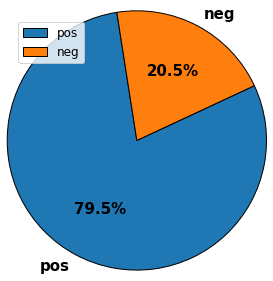

In [14]:
import matplotlib.pyplot as plt
columns_failure_type = train_data['label'].unique().tolist()
plt.rcParams["figure.figsize"] = (15,8)
plt.pie(train_data['label'].value_counts(), autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'}, counterclock=False, startangle=25,
        radius=1.3, labels=columns_failure_type, textprops={'fontsize': 15, 'weight': 'bold'})
plt.legend(columns_failure_type, loc='upper left', fontsize=12)
plt.tight_layout()

for label, count in train_data['label'].value_counts().iteritems():
    print("Jumlah Data Sentimen", label, ":", count)

Berdasarkan persentase dari hasil visualisasi diatas, didapatkan bahwa kelas data memiliki kondisi yang tidak seimbang (Imbalance Data) dimana kelas Positif (pos) terdapat 4341 data (79.5%) sedangkan untuk kelas Negatif 1121 (20.5%). Oleh karena itu perlu dilakukan penanganan

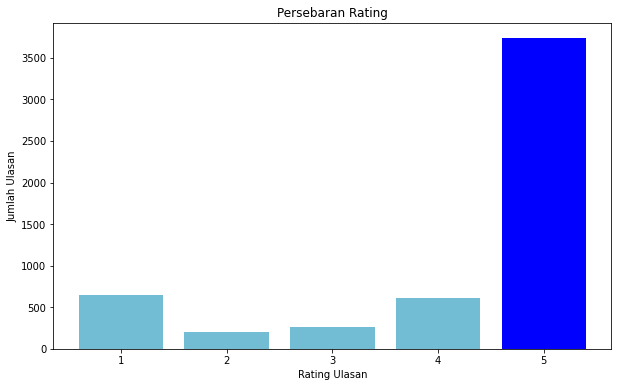

In [15]:
rating_train = train_data.stars.value_counts()
plt.figure(figsize=(10, 6))
colors = ["b", "#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4"]
plt.bar(rating_train.index, rating_train.values, color = colors )
plt.title('Persebaran Rating')
plt.xlabel('Rating Ulasan')
plt.ylabel('Jumlah Ulasan')
plt.show()

Selaras dengan hasil visualisasi jumlah persebaran kelas sentimen, didapatkan dari visualisasi diagram batang diatas yaitu jumlah persebaran rating didominasi oleh rating yang tinggi yaitu rating 4 dan 5 sehingga bisa dikatakan sentimen didominasi oleh sentimen Positif (pos)

#### Data Validation

In [16]:
valid_data.head(10)

,text,label,stars
0,bagussss,pos,5
1,Pengiriman gratis dan produk bervariasi,pos,5
2,Praktis dan mudah aplikasinya digunakan,pos,5
3,No comment,neg,2
4,Aplikasi Belanja Online terbaik di Indonesia ...,pos,5
5,good,pos,4
6,Mudah digunakan,pos,4
7,Ok lah,pos,5
8,"Cukup membantu dl cari barang, lumayan banyak...",pos,5
9,worst e commerce,neg,1


In [17]:
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3012 entries, 0 to 3011
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3012 non-null   object
 1   label   3012 non-null   object
 2   stars   3012 non-null   int8  
dtypes: int8(1), object(2)
memory usage: 50.1+ KB


In [18]:
valid_data.describe(include='all')

,text,label,stars
count,3012,3012,3012.000000
unique,2397,2,NaN
top,Good,pos,NaN
freq,121,2532,NaN
mean,NaN,NaN,4.364874
std,NaN,NaN,1.253359
min,NaN,NaN,1.000000
25%,NaN,NaN,4.000000
50%,NaN,NaN,5.000000
75%,NaN,NaN,5.000000


Berdasarkan rangkuman diatas, terdapat Dua Kelas (Label) Sentiment yaitu Positif (pos) dan Negatif (neg). Dimana Kelas (Label) terbanyak pada Sentimen Positif (pos)

In [19]:
#Identifikasi Missing Value
valid_data.isna().sum()

text     0
label    0
stars    0
dtype: int64

Pada data validation tidak terdapat missing value

In [20]:
#Identifikasi Data Duplikasi
valid_data.duplicated().sum()

574

Terdapat data duplikasi sebanyak 574 data, oleh karena itu perlu dilakukan penanganan

In [21]:
#Menghapus Data Duplikasi dan Mempertahankan Data Pertamanya
valid_data = valid_data.drop_duplicates(subset=['text', 'label', 'stars'], keep='first')

In [22]:
valid_data = valid_data.reset_index(drop=True)
valid_data

,text,label,stars
0,bagussss,pos,5
1,Pengiriman gratis dan produk bervariasi,pos,5
2,Praktis dan mudah aplikasinya digunakan,pos,5
3,No comment,neg,2
4,Aplikasi Belanja Online terbaik di Indonesia ...,pos,5
...,...,...,...
2433,Please add Tracking system Tambahkan fitur tra...,neg,3
2434,"Great app, easy to use, wide range of selecti...",pos,5
2435,I don't know,neg,3
2436,Quite great app.,pos,4


Jumlah Data Sentimen pos : 1965
Jumlah Data Sentimen neg : 473


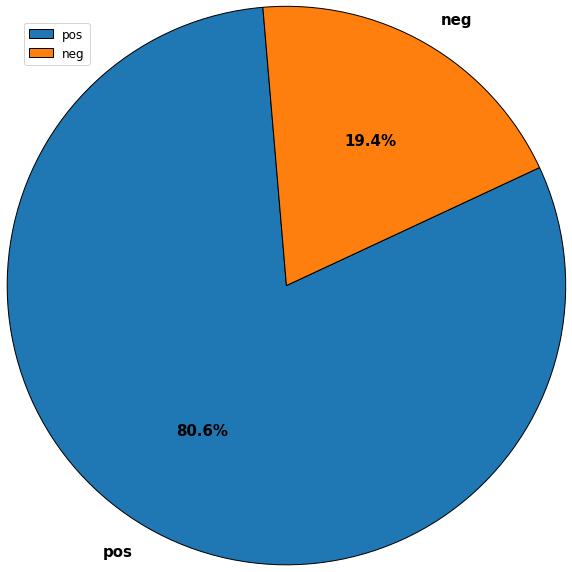

In [23]:
import matplotlib.pyplot as plt
columns_failure_type = valid_data['label'].unique().tolist()
plt.rcParams["figure.figsize"] = (15,8)
plt.pie(valid_data['label'].value_counts(), autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'}, counterclock=False, startangle=25,
        radius=1.3, labels=columns_failure_type, textprops={'fontsize': 15, 'weight': 'bold'})
plt.legend(columns_failure_type, loc='upper left', fontsize=12)
plt.tight_layout()

for label, count in valid_data['label'].value_counts().iteritems():
    print("Jumlah Data Sentimen", label, ":", count)

Berdasarkan hasil visualisasi, terlihat bahwa distribusi kelas data tidak seimbang, atau disebut sebagai Imbalance Data. Persentase menunjukkan bahwa kelas Positif (pos) memiliki 1965 data (80.6%), sementara kelas Negatif hanya memiliki 473 data (19.4.5%). Oleh karena itu, diperlukan tindakan untuk menangani ketidakseimbangan ini.

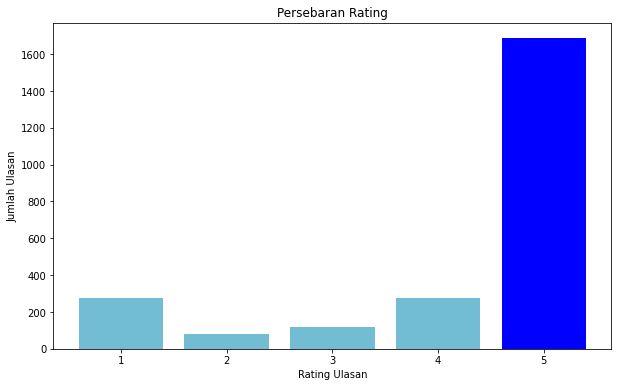

In [24]:
rating_valid = valid_data.stars.value_counts()
plt.figure(figsize=(10, 6))
colors = ["b", "#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4"]
plt.bar(rating_valid.index, rating_valid.values, color = colors )
plt.title('Persebaran Rating')
plt.xlabel('Rating Ulasan')
plt.ylabel('Jumlah Ulasan')
plt.show()

Berdasarkan visualisasi diagram batang yang menggambarkan persebaran kelas sentimen, dapat disimpulkan bahwa mayoritas rating berada pada rating 4 dan 5. Oleh karena itu, dapat disimpulkan bahwa sentimen yang dominan adalah Positif (pos).

## **Pre-Processing Data**

### Cleansing Unnecessary Columns

Menghilangkan kolom yang tidak digunakan pada dataframe

In [25]:
train_data.head(10)

,text,label,stars
0,Halo\n blibli. Sedikit saran untuk gratis ong...,pos,4
1,So far so good. Respon cepat.,pos,5
2,thank,neg,3
3,Aplikasi sering not responding di hp saya (as...,neg,2
4,Gak ada komentar.,pos,5
5,Sangat bagussss,pos,5
6,Thanks for your help and support,pos,4
7,The appplication is easy to use,pos,5
8,Gud,pos,5
9,Gooooooood,pos,5


In [26]:
valid_data.head(10)

,text,label,stars
0,bagussss,pos,5
1,Pengiriman gratis dan produk bervariasi,pos,5
2,Praktis dan mudah aplikasinya digunakan,pos,5
3,No comment,neg,2
4,Aplikasi Belanja Online terbaik di Indonesia ...,pos,5
5,good,pos,4
6,Mudah digunakan,pos,4
7,Ok lah,pos,5
8,"Cukup membantu dl cari barang, lumayan banyak...",pos,5
9,worst e commerce,neg,1


Oleh karena nilai rating tidak digunakan dalam pemrosesan lebih lanjut maka kolom "stars" akan dihapus pada data training dan validation

In [27]:
#Menghapus kolom yang tidak digunakan
train_data = train_data.drop('stars', axis=1)
valid_data = valid_data.drop('stars', axis=1)

### Case Folding

Case folding adalah proses pengubahan huruf dalam suatu teks menjadi format yang seragam, biasanya dengan mengonversi semua huruf menjadi huruf kecil (lowercase). Tujuan dari case folding adalah untuk menyamakan representasi teks yang memiliki huruf kapital dan huruf kecil agar lebih mudah untuk diproses

In [28]:
train_data['text'] = train_data['text'].str.lower()
valid_data['text'] = valid_data['text'].str.lower()

In [29]:
train_data.head(5)

,text,label
0,halo\n blibli. sedikit saran untuk gratis ong...,pos
1,so far so good. respon cepat.,pos
2,thank,neg
3,aplikasi sering not responding di hp saya (as...,neg
4,gak ada komentar.,pos


In [30]:
valid_data.head(5)

,text,label
0,bagussss,pos
1,pengiriman gratis dan produk bervariasi,pos
2,praktis dan mudah aplikasinya digunakan,pos
3,no comment,neg
4,aplikasi belanja online terbaik di indonesia ...,pos


### Remove Newline Characters

"Remove Newline Characters" adalah langkah yang umum yang bertujuan untuk Menghilangkan karakter newline membantu menjaga konsistensi format teks. Newline characters, seperti "\n", dapat muncul dalam teks dan memengaruhi pemrosesan atau analisis teks.

In [31]:
import re
def remove_newline_characters(text):
    cleaned_text = text.replace('\n', ' ')
    return cleaned_text

In [32]:
train_data['text'] = train_data['text'].apply(remove_newline_characters)
valid_data['text'] = valid_data['text'].apply(remove_newline_characters)

### Remove Special Characters

"Remove Special Characters" adalah menghilangkan Special characters, dimana karakter-karakter yang tidak termasuk dalam kategori huruf atau angka biasa. Ini dapat mencakup karakter seperti tanda baca, simbol, dan karakter khusus lainnya. Membantu mencegah masalah saat tokenisasi dan konsistensi teks.

In [33]:
import re
def remove_special_characters(text, remove_digits=True):
  pattern = r'[^a-zA-z0-9\s]'
  text=re.sub(pattern, '', text)
  return text

In [34]:
train_data['text'] = train_data['text'].apply(remove_special_characters)
valid_data['text'] = valid_data['text'].apply(remove_special_characters)

### Remove Double Spaces

"Remove Double Spaces" adalah langkah dalam pemrosesan data teks yang bertujuan untuk menghilangkan spasi berlebihan yang mungkin muncul di antara kata-kata atau di bagian lain dari teks. Spasi berlebihan dapat merugikan dalam beberapa konteks, terutama ketika menganalisis teks atau memproses teks untuk tugas seperti klasifikasi teks.

In [35]:
import re
def remove_double_spaces(text):
    cleaned_text = re.sub(' +', ' ', text)
    return cleaned_text

In [36]:
train_data['text'] = train_data['text'].apply(remove_double_spaces)
valid_data['text'] = valid_data['text'].apply(remove_double_spaces)

### Remove Data with Spaces

"Remove Data with Spaces" merujuk pada langkah menghapus baris atau entri data yang hanya berisi spasi atau karakter whitespace. Dalam konteks ini, data yang hanya terdiri dari karakter spesial akan diubah menjadi spasi sehingga data tersebut dianggap tidak bernilai dan perlu dihapus dari dataset.

In [37]:
def remove_data_with_spaces(row):
    return row['text'].strip() != ''

In [38]:
train_data = train_data[train_data.apply(remove_data_with_spaces, axis=1)]
valid_data = valid_data[valid_data.apply(remove_data_with_spaces, axis=1)]

In [39]:
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

### Normalisasi

Normalisasi teks adalah proses mengubah teks ke dalam bentuk yang lebih standar atau konsisten, umumnya dengan tujuan untuk mempermudah analisis dan pemrosesan lebih lanjut. Banyak ditemukan kata yang tidak baku/standar yaitu berupa kata singkatan seperti yg (yang), aja (saja) dll

In [40]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')  # Download data untuk tokenisasi

# Kamus penggantian kata-kata yang salah
norm = {'yg': 'yang',
        'ga': 'tidak',
        'gak': 'tidak',
        'aja': 'saja',
        'cs': 'customer service',
        'kalo': 'kalau',
        'tp': 'tapi',
        'tdk': 'tidak',
        'n': 'and',
        'dgn': 'dengan',
        'pake': 'pakai',
        'utk': 'untuk',
        'bgt': 'sangat',
        'dr': 'dari',
        'bs': 'bisa',
        'sy': 'saya',
        'jg': 'juga',
        'bli': 'beli',
        'lg': 'lagi',
        'jd': 'jadi',
        'sdh': 'sudah',
        'klo': 'kalau',
        'krn': 'karena',
        'mantab': 'mantap',
        'tgl': 'tanggal',
        'gk': 'tidak',
        'g': 'tidak',
        'dah': 'sudah',
        'thx': 'thank',
        'brg': 'barang',
        'skrg': 'sekarang',
        'trus': 'terus',
        'ori': 'original',
        'blm': 'belum',
        'tau': 'tahu',
        'dapet': 'dapat',
        'bli2': 'blibli',
        'sm': 'sama',
        'u': 'you',
        'kayak': 'seperti',
        'dpt': 'dapat',
        'gabisa': 'tidak bisa',
        'dg': 'dengan',
        'eror': 'error',
        'servicenya': 'service',
        'gitu': 'begitu',
        'barang2': 'barang',
        'dlm': 'dalam',
        'lbh': 'lebih',
        'mulu': 'melulu',
        'appnya': 'application',
        'mantul': 'mantap',
        'blanja': 'belanja',
        'yaa': 'iya',
        'pdhl': 'padahal',
        'ngga': 'tidak',
        'telp': 'telepon',
        'tetep': 'tetap',
        'msh': 'masih',
        'uda': 'sudah',
        'cust': 'customer',
        'bener': 'benar',
        'emang': 'emang',
        'nunggu': 'tunggu',
        'hrs': 'harus',
        'drpd': 'daripada',
        'onlineshop': 'online shop',
        'mantappp': 'mantap',
        'apa2': 'apa',
        'kasi': 'kasih',
        'spt': 'seperti',
        'musti': 'mesti',
        'smoga': 'semoga',
        'tiba2': 'mendadak',
        'bbrp': 'beberapa',
        'nyoba': 'coba',
        'barang2nya': 'barang',
        'ngasih': 'kasih',
        'dri': 'dari',
        'bsa': 'bisa',
        'dll': 'dan lain lain',
        'kl': 'kalau',
        'berkalikali': 'sering',
        'ngaco': 'sembarangan',
        'tsb': 'tersebut',
        'gud': 'good',
        'benar2': 'benar',
        'ngerti': 'mengerti',
        'ato': 'atau',
        'nyesel': 'menyesal',
        'disc': 'discount',
        'sgt': 'sangat',
        'bibli': 'blibli',
        'pls': 'please',
        'bgus': 'bagus',
        'bnyk': 'banyak',
        'jgn': 'jangan',
        'org': 'orang',
        'sering2': 'sering',
        'rb': 'ribu',
        'goood': 'good',
        'guys': 'friend',
        'knp': 'kenapa',
        'k': 'ke',
        'tks': 'thanks',
        'hape': 'handphone',
        'pd': 'pada',
        'cpt': 'cepat',
        'ud': 'sudah',
        'tq': 'thanks',
        'penggunaannya': 'penggunaan',
        'ajah': 'saja',
        'apik': 'bagus',
        'apl': 'aplikasi',
        'sya': 'saya',
        'ama': 'sama',
        'gooooooood': 'good',
        'trs': 'terus',
        'bagussss': 'bagus',
        'itt': 'it',
        'okeeeeyyy': 'ok',
        'jauhhh': 'jauh',
        'bagussss': 'bagus'
        }


train_data['text'] = train_data['text'].apply(lambda x: ' '.join([norm.get(token, token) for token in word_tokenize(x.lower())]))
valid_data['text'] = valid_data['text'].apply(lambda x: ' '.join([norm.get(token, token) for token in word_tokenize(x.lower())]))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Stopword

Stopwords adalah kata-kata umum yang biasanya dianggap tidak memiliki nilai informasi signifikan dalam analisis teks atau pemrosesan bahasa alami. Pada dataset yang dipakai pada projek ini terdiri dari beberapa bahasa sehingga dalam pemrosesan stopword perlu dilakukan identifikasi terlebih dahulu guna menentukan proses lebih lanjut

Identifikasi Bahasa Dalam Data Training

In [41]:
import langid
import pandas as pd
from collections import Counter

def identify_language_percentage(text):
    words = text.split()
    languages = [langid.classify(word)[0] for word in words]

    total_words = len(words)
    language_counts = Counter(languages)
    language_percentages = {lang: count / total_words * 100 for lang, count in language_counts.items()}

    return language_percentages

# Identifikasi bahasa dan tambahkan kolom persentase
train_data['language_percentages'] = train_data['text'].apply(identify_language_percentage)

# Menghitung rata-rata persentase untuk setiap bahasa
overall_percentages = {}

for _, row in train_data.iterrows():
    for lang, percentage in row['language_percentages'].items():
        overall_percentages[lang] = overall_percentages.get(lang, 0) + percentage / len(train_data)

# Menampilkan hanya 3 teratas
top_languages = dict(sorted(overall_percentages.items(), key=lambda item: item[1], reverse=True)[:3])

print("Top 3 Bahasa:")
for lang, percentage in top_languages.items():
    print(f"{lang}: {percentage:.2f}%")


Top 3 Bahasa:
en: 74.24%
id: 8.93%
de: 2.64%


Identifikasi Bahasa Dalam Data Validation

In [42]:
import langid
import pandas as pd
from collections import Counter

def identify_language_percentage(text):
    words = text.split()
    languages = [langid.classify(word)[0] for word in words]

    total_words = len(words)
    language_counts = Counter(languages)
    language_percentages = {lang: count / total_words * 100 for lang, count in language_counts.items()}

    return language_percentages

# Identifikasi bahasa dan tambahkan kolom persentase
valid_data['language_percentages'] = valid_data['text'].apply(identify_language_percentage)

# Menghitung rata-rata persentase untuk setiap bahasa
overall_percentages = {}

for _, row in valid_data.iterrows():
    for lang, percentage in row['language_percentages'].items():
        overall_percentages[lang] = overall_percentages.get(lang, 0) + percentage / len(valid_data)

# Menampilkan hanya 3 teratas
top_languages = dict(sorted(overall_percentages.items(), key=lambda item: item[1], reverse=True)[:3])

print("Top 3 Bahasa:")
for lang, percentage in top_languages.items():
    print(f"{lang}: {percentage:.2f}%")

Top 3 Bahasa:
en: 74.00%
id: 8.80%
de: 3.08%


Berdasarkan identifikasi bahasa diatas didapatkan bahwa mayoritas bahasa yang digunakan terdiri dari kata dalam bahasa inggris dan bahasa indonesia. Oleh karena itu, akan dilakukan pemrosesan stopwords dengan menggunakan dua bahasa yaitu bahasa indonesia dan bahasa inggris (bilingual)

Identifikasi Stopwords Pada Data

In [43]:
#Data Training
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words_id = set(stopwords.words('indonesian'))
stop_words_en = set(stopwords.words('english'))

def identify_mixed_language_words(sentence):
    words = sentence.split()

    mixed_language_words = {
        'id': [],
        'en': []
    }

    for word in words:
        if word.lower() in stop_words_id:
            mixed_language_words['id'].append(word)
        elif word.lower() in stop_words_en:
            mixed_language_words['en'].append(word)

    return mixed_language_words

train_data['mixed_language_words'] = train_data['text'].apply(identify_mixed_language_words)
train_data['mixed_language_words'] = train_data['text'].apply(identify_mixed_language_words)

# Menampilkan hasil
pd.options.display.max_columns = None
train_data[['text', 'mixed_language_words', 'label']]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,mixed_language_words,label
0,halo blibli sedikit saran untuk gratis ongkirn...,"{'id': ['sedikit', 'untuk', 'yang', 'di', 'jad...",pos
1,so far so good respon cepat,"{'id': [], 'en': ['so', 'so']}",pos
2,thank,"{'id': [], 'en': []}",neg
3,aplikasi sering not responding di hp saya asus...,"{'id': ['sering', 'di', 'saya'], 'en': ['not']}",neg
4,tidak ada komentar,"{'id': ['tidak', 'ada'], 'en': []}",pos
...,...,...,...
5430,very useful,"{'id': [], 'en': ['very']}",pos
5431,sip kejelasan pembayaran kejelasan stok barang,"{'id': [], 'en': []}",pos
5432,senang belanja disini,"{'id': ['disini'], 'en': []}",pos
5433,good application very helpfull and best price,"{'id': [], 'en': ['very', 'and']}",pos


In [44]:
#Data Validation
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words_id = set(stopwords.words('indonesian'))
stop_words_en = set(stopwords.words('english'))

def identify_mixed_language_words(sentence):
    words = sentence.split()

    mixed_language_words = {
        'id': [],
        'en': []
    }

    for word in words:
        if word.lower() in stop_words_id:
            mixed_language_words['id'].append(word)
        elif word.lower() in stop_words_en:
            mixed_language_words['en'].append(word)

    return mixed_language_words

valid_data['mixed_language_words'] = valid_data['text'].apply(identify_mixed_language_words)
valid_data['mixed_language_words'] = valid_data['text'].apply(identify_mixed_language_words)

# Menampilkan hasil
pd.options.display.max_columns = None
valid_data[['text', 'mixed_language_words', 'label']]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,mixed_language_words,label
0,bagus,"{'id': [], 'en': []}",pos
1,pengiriman gratis dan produk bervariasi,"{'id': ['dan'], 'en': []}",pos
2,praktis dan mudah aplikasinya digunakan,"{'id': ['dan', 'digunakan'], 'en': []}",pos
3,no comment,"{'id': [], 'en': ['no']}",neg
4,aplikasi belanja online terbaik di indonesia s...,"{'id': ['di', 'saat', 'ini'], 'en': []}",pos
...,...,...,...
2418,please add tracking system tambahkan fitur tra...,"{'id': ['yang', 'dalam', 'dong'], 'en': []}",neg
2419,great app easy to use wide range of selections...,"{'id': [], 'en': ['to', 'of']}",pos
2420,i dont know,"{'id': [], 'en': ['i']}",neg
2421,quite great app,"{'id': [], 'en': []}",pos


Dari hasil identifikasi stopwords, didapatkan beberapa kata dari bahasa indonesia dan bahasa inggris yang selanjutnya kata tersebut akan dilakukan proses penghapusan

Stopword Removal

In [45]:
#Data Training
def remove_detected_words(row):
    text_words = row['text'].split()
    detected_id_words = row['mixed_language_words']['id']
    detected_en_words = row['mixed_language_words']['en']

    cleaned_text = ' '.join([word for word in text_words if word.lower() not in detected_id_words and word.lower() not in detected_en_words])

    return cleaned_text

# Menerapkan fungsi ke seluruh DataFrame
train_data['cleaned_text'] = train_data.apply(remove_detected_words, axis=1)

train_data[['text', 'mixed_language_words', 'cleaned_text', 'label']]

,text,mixed_language_words,cleaned_text,label
0,halo blibli sedikit saran untuk gratis ongkirn...,"{'id': ['sedikit', 'untuk', 'yang', 'di', 'jad...",halo blibli saran gratis ongkirnya minimum 200...,pos
1,so far so good respon cepat,"{'id': [], 'en': ['so', 'so']}",far good respon cepat,pos
2,thank,"{'id': [], 'en': []}",thank,neg
3,aplikasi sering not responding di hp saya asus...,"{'id': ['sering', 'di', 'saya'], 'en': ['not']}",aplikasi responding hp asus zenfone t001f,neg
4,tidak ada komentar,"{'id': ['tidak', 'ada'], 'en': []}",komentar,pos
...,...,...,...,...
5430,very useful,"{'id': [], 'en': ['very']}",useful,pos
5431,sip kejelasan pembayaran kejelasan stok barang,"{'id': [], 'en': []}",sip kejelasan pembayaran kejelasan stok barang,pos
5432,senang belanja disini,"{'id': ['disini'], 'en': []}",senang belanja,pos
5433,good application very helpfull and best price,"{'id': [], 'en': ['very', 'and']}",good application helpfull best price,pos


In [46]:
#Data Validation
def remove_detected_words(row):
    text_words = row['text'].split()
    detected_id_words = row['mixed_language_words']['id']
    detected_en_words = row['mixed_language_words']['en']

    cleaned_text = ' '.join([word for word in text_words if word.lower() not in detected_id_words and word.lower() not in detected_en_words])

    return cleaned_text

# Menerapkan fungsi ke seluruh DataFrame
valid_data['cleaned_text'] = valid_data.apply(remove_detected_words, axis=1)

valid_data[['text', 'mixed_language_words', 'cleaned_text', 'label']]

,text,mixed_language_words,cleaned_text,label
0,bagus,"{'id': [], 'en': []}",bagus,pos
1,pengiriman gratis dan produk bervariasi,"{'id': ['dan'], 'en': []}",pengiriman gratis produk bervariasi,pos
2,praktis dan mudah aplikasinya digunakan,"{'id': ['dan', 'digunakan'], 'en': []}",praktis mudah aplikasinya,pos
3,no comment,"{'id': [], 'en': ['no']}",comment,neg
4,aplikasi belanja online terbaik di indonesia s...,"{'id': ['di', 'saat', 'ini'], 'en': []}",aplikasi belanja online terbaik indonesia,pos
...,...,...,...,...
2418,please add tracking system tambahkan fitur tra...,"{'id': ['yang', 'dalam', 'dong'], 'en': []}",please add tracking system tambahkan fitur tra...,neg
2419,great app easy to use wide range of selections...,"{'id': [], 'en': ['to', 'of']}",great app easy use wide range selections free ...,pos
2420,i dont know,"{'id': [], 'en': ['i']}",dont know,neg
2421,quite great app,"{'id': [], 'en': []}",quite great app,pos


Bisa dilihat data hasil dari proses "Removal Stopwords", kalimat ulasan akan menjadi ramping, menghiraukan kata-kata yang tidak mempunyai informasi signifikan

Identifikasi Nilai yang hilang pada Baris data setelah dilakukan proses Removal Stopwords

In [47]:
train_data[train_data['cleaned_text']=='']

,text,label,language_percentages,mixed_language_words,cleaned_text
1261,tidak tidak,neg,{'id': 100.0},"{'id': ['tidak', 'tidak'], 'en': []}",
1462,baru,neg,{'en': 100.0},"{'id': ['baru'], 'en': []}",
1837,d,pos,{'en': 100.0},"{'id': [], 'en': ['d']}",
2019,apa saja ada kok,pos,"{'en': 75.0, 'fi': 25.0}","{'id': ['apa', 'saja', 'ada', 'kok'], 'en': []}",
2545,the,pos,{'en': 100.0},"{'id': [], 'en': ['the']}",
2673,why,neg,{'en': 100.0},"{'id': [], 'en': ['why']}",
3368,so so,neg,{'en': 100.0},"{'id': [], 'en': ['so', 'so']}",
3377,luar biasa,pos,"{'en': 50.0, 'es': 50.0}","{'id': ['luar', 'biasa'], 'en': []}",
4799,biasa saja,pos,"{'es': 50.0, 'en': 50.0}","{'id': ['biasa', 'saja'], 'en': []}",
5123,more,pos,{'en': 100.0},"{'id': [], 'en': ['more']}",


In [48]:
valid_data[valid_data['cleaned_text']=='']

,text,label,language_percentages,mixed_language_words,cleaned_text
96,just so so,pos,{'en': 100.0},"{'id': [], 'en': ['just', 'so', 'so']}",
159,aku,pos,{'en': 100.0},"{'id': ['aku'], 'en': []}",
441,baik,pos,{'lt': 100.0},"{'id': ['baik'], 'en': []}",
737,no,neg,{'en': 100.0},"{'id': [], 'en': ['no']}",
845,cukup baik,pos,"{'fi': 50.0, 'lt': 50.0}","{'id': ['cukup', 'baik'], 'en': []}",
1178,so so,neg,{'en': 100.0},"{'id': [], 'en': ['so', 'so']}",
1596,so so,pos,{'en': 100.0},"{'id': [], 'en': ['so', 'so']}",
1831,luar biasa,pos,"{'en': 50.0, 'es': 50.0}","{'id': ['luar', 'biasa'], 'en': []}",
1887,sejauh ini tidak ada masalah,pos,"{'et': 20.0, 'en': 40.0, 'id': 40.0}","{'id': ['sejauh', 'ini', 'tidak', 'ada', 'masa...",
2175,semakin lebih baik,pos,"{'en': 33.33333333333333, 'sl': 33.33333333333...","{'id': ['semakin', 'lebih', 'baik'], 'en': []}",


Berdasarkan hasil identifikasi, didapatkan bahwa terdapat baris data yang tidak memiliki nilai  pada kolom ulasan sebagai akibat proses "Removal Stopwords" dimana baris data yang tidak memiliki nilai tersebut berisi ulasan yang terdiri dari kalimat atau kata Stopwords. Oleh karena itu perlu dilakukan penghapusan baris data

In [49]:
def remove_data_with_spaces2(row):
    return row['cleaned_text'].strip() != ''
train_data = train_data[train_data.apply(remove_data_with_spaces2, axis=1)]
valid_data = valid_data[valid_data.apply(remove_data_with_spaces2, axis=1)]

train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

### Tokenisasi

Tokenisasi adalah proses memecah suatu teks atau dokumen menjadi unit-unit kecil yang lebih kecil, yang disebut token. Token dapat berupa kata-kata, frasa, atau simbol-simbol tertentu yang memiliki makna dalam konteks bahasa atau tugas pemrosesan teks. Tokenisasi akan dilakukan sebelum dilakukan proses stemming

In [50]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

train_data['Token Kata'] = train_data['cleaned_text'].apply(lambda x: word_tokenize(x))
valid_data['Token Kata'] = valid_data['cleaned_text'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [51]:
train_data[['cleaned_text', 'Token Kata', 'label']].head()

,cleaned_text,Token Kata,label
0,halo blibli saran gratis ongkirnya minimum 200...,"[halo, blibli, saran, gratis, ongkirnya, minim...",pos
1,far good respon cepat,"[far, good, respon, cepat]",pos
2,thank,[thank],neg
3,aplikasi responding hp asus zenfone t001f,"[aplikasi, responding, hp, asus, zenfone, t001f]",neg
4,komentar,[komentar],pos


In [52]:
valid_data[['cleaned_text', 'Token Kata', 'label']].head()

,cleaned_text,Token Kata,label
0,bagus,[bagus],pos
1,pengiriman gratis produk bervariasi,"[pengiriman, gratis, produk, bervariasi]",pos
2,praktis mudah aplikasinya,"[praktis, mudah, aplikasinya]",pos
3,comment,[comment],neg
4,aplikasi belanja online terbaik indonesia,"[aplikasi, belanja, online, terbaik, indonesia]",pos


### Stemming

Stemming adalah pemrosesan teks yang bertujuan untuk mengurangi kata-kata ke bentuk dasarnya atau "akar kata" (stem). Tujuan utamanya adalah untuk menghapus infleksi kata dan membawa kata-kata ke bentuk dasar yang memiliki makna dasar yang sama. Ini membantu dalam mengekstrak fitur-fitur utama dari teks sehingga dapat lebih mudah dianalisis atau diproses. Pada projek ini akan dilakukan stemming untuk kata dalam bahasa inggris dan bahasa indonesia

In [53]:
#Stemming untuk Bahasa Inggris
import pandas as pd
import nltk
from nltk.stem import PorterStemmer

# Download data untuk tokenisasi (punkt) dan stemming (porter)
nltk.download('punkt')

# Proses stemming untuk setiap token dalam kolom 'text'
stemmer = PorterStemmer()
train_data['stemmed_text'] = train_data['Token Kata'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])
valid_data['stemmed_text'] = valid_data['Token Kata'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [54]:
train_data[['cleaned_text', 'Token Kata', 'stemmed_text', 'label']].head()

,cleaned_text,Token Kata,stemmed_text,label
0,halo blibli saran gratis ongkirnya minimum 200...,"[halo, blibli, saran, gratis, ongkirnya, minim...","[halo, blibli, saran, grati, ongkirnya, minimu...",pos
1,far good respon cepat,"[far, good, respon, cepat]","[far, good, respon, cepat]",pos
2,thank,[thank],[thank],neg
3,aplikasi responding hp asus zenfone t001f,"[aplikasi, responding, hp, asus, zenfone, t001f]","[aplikasi, respond, hp, asu, zenfon, t001f]",neg
4,komentar,[komentar],[komentar],pos


In [55]:
valid_data[['cleaned_text', 'Token Kata', 'stemmed_text', 'label']].head()

,cleaned_text,Token Kata,stemmed_text,label
0,bagus,[bagus],[bagu],pos
1,pengiriman gratis produk bervariasi,"[pengiriman, gratis, produk, bervariasi]","[pengiriman, grati, produk, bervariasi]",pos
2,praktis mudah aplikasinya,"[praktis, mudah, aplikasinya]","[prakti, mudah, aplikasinya]",pos
3,comment,[comment],[comment],neg
4,aplikasi belanja online terbaik indonesia,"[aplikasi, belanja, online, terbaik, indonesia]","[aplikasi, belanja, onlin, terbaik, indonesia]",pos


In [56]:
#Stemming untuk Bahasa Indonesia
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Inisialisasi Stemmer untuk bahasa Indonesia
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# Proses stemming untuk setiap token dalam kolom 'text'
train_data['stemmed_text'] = train_data['stemmed_text'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])
valid_data['stemmed_text'] = valid_data['stemmed_text'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])

Setelah dilakukan proses stemming maka data akan dilakukan proses konversi dari tokenisasi menjadi kalimat kembali

In [57]:
#konversi kembali ke kalimat
train_data['reconstructed_text'] = train_data['stemmed_text'].apply(lambda tokens: ' '.join(tokens))
valid_data['reconstructed_text'] = valid_data['stemmed_text'].apply(lambda tokens: ' '.join(tokens))

In [58]:
train_data = train_data[['reconstructed_text', 'label']].copy()
train_data.head()

,reconstructed_text,label
0,halo blibli saran grati ongkirnya minimum 200r...,pos
1,far good respon cepat,pos
2,thank,neg
3,aplikasi respond hp asu zenfon t001f,neg
4,komentar,pos


In [59]:
valid_data = valid_data[['reconstructed_text', 'label']].copy()
valid_data.head()

,reconstructed_text,label
0,bagu,pos
1,kirim grati produk variasi,pos
2,prakti mudah aplikasi,pos
3,comment,neg
4,aplikasi belanja onlin baik indonesia,pos


### **Label Encoding**

Label encoding adalah proses mengonversi kategori atau label dalam variabel target menjadi nilai numerik. Dalam konteks ini, setiap kategori diberi label unik dalam bentuk nilai numerik. Tujuannya adalah untuk memungkinkan model pembelajaran mesin atau algoritma dapat memahami dan memproses variabel target yang awalnya berbentuk kategori. Kelas Sentimen Positif (pos) akan diwakili oleh nilai numerik 1 dan Kelas Sentimen Negatif (neg) akan diwakili oleh nilai numerik 0

In [60]:
train_data['label'] = train_data['label'].replace({'pos': 1, 'neg': 0})
valid_data['label'] = valid_data['label'].replace({'pos': 1, 'neg': 0})

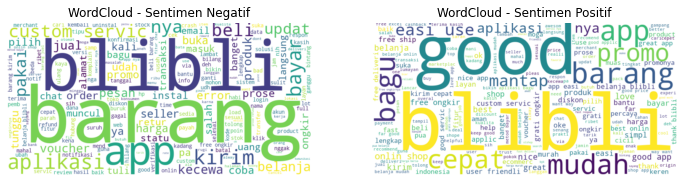

In [61]:
from wordcloud import WordCloud
# Membuat WordCloud untuk sentimen negatif
negatif_text = ' '.join(train_data[train_data['label'] == 0]['reconstructed_text'])
wordcloud_negatif = WordCloud(width=800, height=400, background_color='white').generate(negatif_text)

# Membuat WordCloud untuk sentimen positif
positif_text = ' '.join(train_data[train_data['label'] == 1]['reconstructed_text'])
wordcloud_positif = WordCloud(width=800, height=400, background_color='white').generate(positif_text)

# Menampilkan WordCloud untuk sentimen negatif
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Sentimen Negatif')

# Menampilkan WordCloud untuk sentimen positif
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Sentimen Positif')

plt.show()

## **Splitting Data**

In [75]:
X_train = train_data['reconstructed_text']
X_test = valid_data['reconstructed_text']
y_train = train_data['label']
y_test = valid_data['label']

persentase_train = (len(X_train)/(len(X_train)+len(X_test)))*100
persentase_validation = (len(X_test)/(len(X_train)+len(X_test)))*100
print("Data Training: {:.2f}".format(persentase_train))
print("Data Validation: {:.2f}".format(persentase_validation))

Data Training: 69.22
Data Validation: 30.78


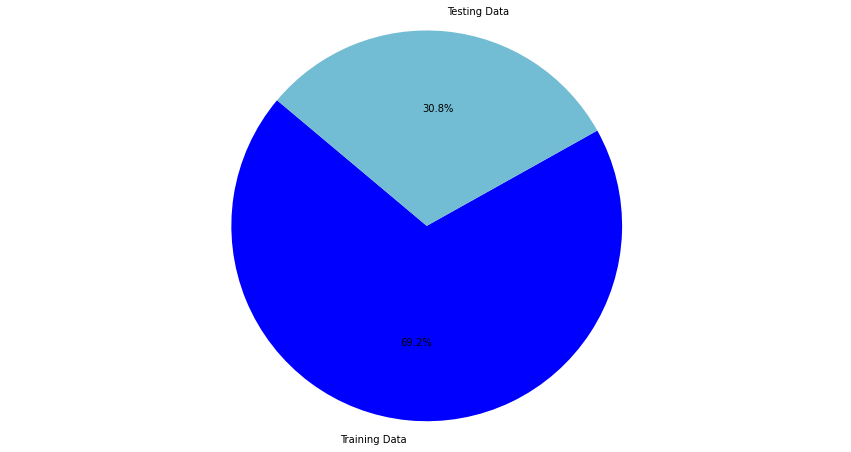

In [64]:
# Data
sizes = [len(X_train), len(X_test)]
labels = ['Training Data', 'Testing Data']
colors = ["b", "#72BCD4"]
explode = (0.1, 0)  # Explode the 1st slice (Training Data)

# Pie plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


## **TF-IDF**

TF-IDF adalah singkatan dari "Term Frequency-Inverse Document Frequency." Ini adalah metode statistik yang digunakan dalam pemrosesan teks dan temu balik informasi untuk menilai seberapa penting sebuah kata (term) dalam suatu dokumen dalam kumpulan dokumen (korpus). Metode ini memberikan skor numerik kepada setiap kata berdasarkan seberapa sering kata tersebut muncul dalam dokumen tertentu dan seberapa unik kata tersebut dalam seluruh korpus.

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [67]:
#Save model TF-IDF
joblib.dump(vectorizer, 'TF-IDF.joblib')

['TF-IDF.joblib']

Model Vectorizer ini yang akan dipakai pada saat pemrosesan API

## **SMOTE**

SMOTE adalah singkatan dari "Synthetic Minority Over-sampling Technique." Ini adalah metode yang digunakan dalam masalah ketidakseimbangan kelas (class imbalance) pada pembelajaran mesin, khususnya pada tugas klasifikasi. Dikembangkan untuk menangani situasi di mana kelas minoritas (kelas yang memiliki sedikit contoh) kurang diwakili dalam data pelatihan, SMOTE berusaha untuk meningkatkan jumlah sampel dalam kelas minoritas dengan cara menciptakan sampel-sampel sintetis yang mirip dengan sampel-sampel yang sudah ada.

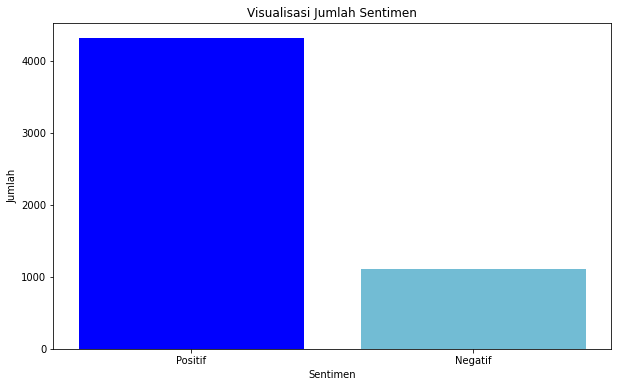

In [68]:
y_train_mapped = y_train.map({0: 'Negatif', 1: 'Positif'})
label = y_train_mapped.value_counts()
plt.figure(figsize=(10, 6))
colors = ["b", "#72BCD4"]
plt.bar(label.index, label.values, color = colors)
plt.title('Visualisasi Jumlah Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

Berdasarkan hasil visualisasi jumlah persebaran kelas dari sentimen, didapatkan bahwa kelas sentimen positif jauh lebih banyak dibandingkan oleh sentimen negatif (imbalanced data) oleh karena itu perlu dilakukan proses penyeimbangan dengan menggunakan SMOTE guna kelas dari data menjadi seimbang sehingga model tidak bias prediksi.

In [69]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

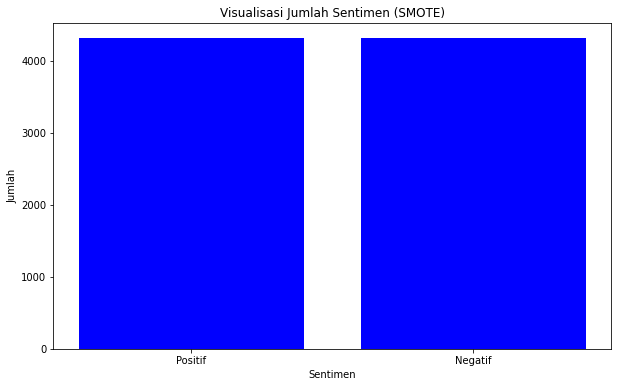

In [70]:
y_resampled_mapped_ = y_resampled.map({0: 'Negatif', 1: 'Positif'})
label_smote = y_resampled_mapped_.value_counts()
plt.figure(figsize=(10, 6))
colors = ["b", "b"]
plt.bar(label_smote.index, label_smote.values, color = colors)
plt.title('Visualisasi Jumlah Sentimen (SMOTE)')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

Dari hasil SMOTE, maka kelas data menjadi seimbang sehingga dapat meningkatkan kinerja model pada kelas minoritas. Ini membantu mencegah model mengabaikan kelas minoritas dan memastikan bahwa model dapat belajar dari kedua kelas dengan seimbang serta menghindari terjadinya bias prediksi akibat data imbalance.

## **Modelling**

Regresi logistik adalah metode statistik yang digunakan untuk memodelkan hubungan antara satu atau lebih variabel independen (prediktor) dengan variabel dependen biner (hasil yang dapat berupa dua kategori: positif atau negatif). Tujuan regresi logistik adalah memprediksi probabilitas kejadian suatu peristiwa pada kelompok tertentu berdasarkan nilai-nilai variabel independen.

Dalam regresi logistik, fungsi logistik (atau sigmoid) digunakan untuk mengubah kombinasi linear dari variabel independen menjadi nilai yang berada dalam rentang antara 0 dan 1. Fungsi logistik memiliki bentuk kurva S, yang memungkinkan kita mengartikan output sebagai probabilitas kejadian sukses.

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [72]:
model = LogisticRegression(random_state=42)
model.fit(X_resampled, y_resampled)

# Prediksi
y_pred = model.predict(X_test_tfidf)

# Evaluasi
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

classification_report_result = classification_report(y_test, y_pred)
print('Classification Report:\n', classification_report_result)

Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.80      0.73       471
           1       0.95      0.91      0.93      1941

    accuracy                           0.89      2412
   macro avg       0.81      0.85      0.83      2412
weighted avg       0.90      0.89      0.89      2412



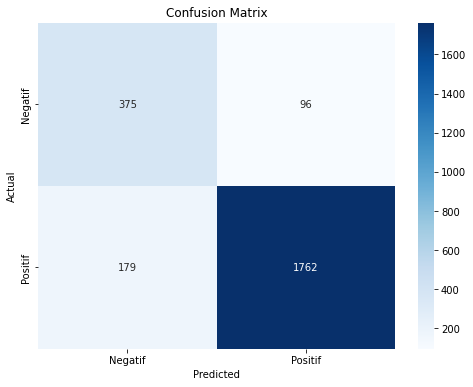

In [78]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Berdasarkan hasil evaluasi model Logistic Regression untuk tugas klasifikasi teks sentimen positif dan negatif, dapat disimpulkan bahwa model ini memberikan kinerja yang umumnya baik. Dengan tingkat akurasi sebesar 89%, model dapat memprediksi sentimen dengan tepat pada sebagian besar kasus. Meskipun demikian, terdapat beberapa aspek yang perlu diperhatikan. Model cenderung lebih baik dalam mengenali sentimen positif, dengan presisi, recall, dan F1-score yang tinggi. Di sisi lain, untuk sentimen negatif, presisi relatif lebih rendah, menunjukkan kecenderungan untuk memberikan false positives. Oleh karena itu, ada potensi untuk meningkatkan kinerja model khususnya dalam mengidentifikasi sentimen negatif. 

In [73]:
#Save Model Klasifikasi
joblib.dump(model, 'logreg.joblib')

['logreg.joblib']

Model akan ini yang akan digunakan untuk mengklasifikasi teks inputan pada API